In [1]:
# Import all libraries

import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt

In [188]:
# # Rings CoM as input

# filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Abdullah Data\ring_centers.npy"
# data = np.load(filePath)

In [2]:
# # All atoms as input
# # Brute Force

filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\traj2-55k-65k.npy"
data = np.load(filePath)

In [12]:
# View Data Shape
data = np.array(data)
data

array([[[12.80264282,  2.91003132, 33.40210342],
        [12.80264282,  2.91003132, 33.40210342],
        [12.80264282,  2.91003132, 33.40210342],
        ...,
        [10.94823742,  1.99642873, 33.80776215],
        [10.94823742,  1.99642873, 33.80776215],
        [10.94823742,  1.99642873, 33.80776215]],

       [[12.6194458 ,  4.34170294, 34.10076141],
        [12.6194458 ,  4.34170294, 34.10076141],
        [12.6194458 ,  4.34170294, 34.10076141],
        ...,
        [10.91374207,  3.22600341, 34.74869156],
        [10.91374207,  3.22600341, 34.74869156],
        [10.91374207,  3.22600341, 34.74869156]],

       [[11.17844105,  4.9661293 , 33.90523911],
        [11.17844105,  4.9661293 , 33.90523911],
        [11.17844105,  4.9661293 , 33.90523911],
        ...,
        [ 9.96331978,  4.33637428, 34.30192566],
        [ 9.96331978,  4.33637428, 34.30192566],
        [ 9.96331978,  4.33637428, 34.30192566]],

       ...,

       [[ 5.33915758, 49.49307632, 64.90279388],
        [ 5

In [3]:
# Transpose the data for Convoy algorithm

data1 = list()
for x in range(6126):
    
    data1.append(data[4300:5000,x,0:3].tolist())

data = data1

In [192]:
# cluster = DBSCAN(eps=9, min_samples=4).fit(data[0])

# print("Number of Clusters = ", max(cluster.labels_)+1)

In [4]:
class ConvoyCandidate(object):
    """
    Attributes:
        indices(set): The object indices assigned to the convoy
        is_assigned (bool):
        start_time (int):  The start index of the convoy
        end_time (int):  The last index of the convoy
    """
    __slots__ = ('indices', 'is_assigned', 'start_time', 'end_time')

    def __init__(self, indices, is_assigned, start_time, end_time):
        self.indices = indices
        self.is_assigned = is_assigned
        self.start_time = start_time
        self.end_time = end_time

    def __repr__(self):
        return '<%r %r indices=%r, is_assigned=%r, start_time=%r, end_time=%r>' % (self.__class__.__name__, id(self), self.indices, self.is_assigned, self.start_time, self.end_time)

In [5]:
class CMC(object):
    """Coherence Moving Cluster (CMC) algorithm

    Attributes:
        k (int):  Min number of consecutive timestamps to be considered a convoy
        m (int):  Min number of elements to be considered a convoy
    """
    def __init__(self, clf, k, m):
        self.clf = clf
        self.k = k
        self.m = m

    def fit_predict(self, X, y=None, sample_weight=None):
        convoy_candidates = set()
        columns = len(X[0])
        column_iterator = range(columns)
        output_convoys = []

        for column in column_iterator:
            current_convoy_candidates = set()
            values = [row[column] if isinstance(row[column], (list, set)) else [row[column]] for row in X]
            if len(values) < self.m:
                continue
            clusters = self.clf.fit_predict(values, y=y, sample_weight=sample_weight)
            unique_clusters = set(clusters)
            clusters_indices = dict((cluster, ConvoyCandidate(indices=set(), is_assigned=False, start_time=None, end_time=None)) for cluster in unique_clusters)

            for index, cluster_assignment in enumerate(clusters):
                clusters_indices[cluster_assignment].indices.add(index)

            # update existing convoys
            for convoy_candidate in convoy_candidates:
                convoy_candidate_indices = convoy_candidate.indices
                convoy_candidate.is_assigned = False
                for cluster in unique_clusters:
                    cluster_indices = clusters_indices[cluster].indices
                    cluster_candidate_intersection = cluster_indices & convoy_candidate_indices
                    if len(cluster_candidate_intersection) < self.m:
                        continue
                    convoy_candidate.indices = cluster_candidate_intersection
                    current_convoy_candidates.add(convoy_candidate)
                    convoy_candidate.end_time = column
                    clusters_indices[cluster].is_assigned = convoy_candidate.is_assigned = True

                # check if candidates qualify as convoys
                candidate_life_time = (convoy_candidate.end_time - convoy_candidate.start_time) + 1
                if (not convoy_candidate.is_assigned or column == column_iterator[-1]) and candidate_life_time >= self.k:
                    output_convoys.append(convoy_candidate)

            # create new candidates
            for cluster in unique_clusters:
                cluster_data = clusters_indices[cluster]
                if cluster_data.is_assigned:
                    continue
                cluster_data.start_time = cluster_data.end_time = column
                current_convoy_candidates.add(cluster_data)
            convoy_candidates = current_convoy_candidates
        return output_convoys

In [6]:
# Clustering using DBSCAN
clustering_clf = DBSCAN(eps=2.13)


In [196]:
# # # # Test data of 3D Coordinates
# # # # Elements (Molecules) are in row, timesteps are in column

# data = ([[3,1,3],[3,2,4],[2,4,5]],
#         [[4,2,2],[6,2,3],[4,4,5]],
#         [[1,1,3],[51,2,-1],[55,3,0]],
#         [[51,2,1],[52,2,4],[56,-3, 2]])

In [7]:
# Min elements for convoy = m
# Min consecutive timesteps = k

clf = CMC(clustering_clf, k=50, m=30)

# Convoy calculation using Test data
convoys = clf.fit_predict(data)
print("Total number of Convoys =", len(convoys))

Total number of Convoys = 28


In [8]:
# file = open("output.txt", "w")

for convoy in convoys:
    print('Detected Convoy')
    print('No of elements in the Convoy',len(convoy.indices))  
#     for i in convoy.indices:
#         print('%i: %r - Start Time: %r, End Time: %r' % (i, data[i], convoy.start_time, convoy.end_time))
    print(convoy)
#     file.write('%r - S: %r, E: %r\n' % (convoy.indices, convoy.start_time, convoy.end_time))
#     file.write(str(convoy.start_time))
#     file.write(str(convoy.end_time))
# file.close()

Detected Convoy
No of elements in the Convoy 30
<'ConvoyCandidate' 2682579032896 indices={1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1829, 1830, 1842, 2612, 1854, 1886, 1887, 1888, 1889, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555}, is_assigned=False, start_time=0, end_time=199>
Detected Convoy
No of elements in the Convoy 33
<'ConvoyCandidate' 2680495186304 indices={5640, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4935, 4936, 4948, 5614, 5615, 5616, 5617, 5618, 5619, 5620, 5621, 5631}, is_assigned=False, start_time=0, end_time=199>
Detected Convoy
No of elements in the Convoy 66
<'ConvoyCandidate' 2680495220928 indices={3456, 3465, 3477, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3489, 3377, 3449, 3446, 4155, 4156, 3389, 4157, 4158, 4159, 4160, 4161, 4162, 3447, 3448, 3401, 3402, 3403, 3404, 3405, 3406

In [199]:
# filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Abdullah Data\ring_centers.npy"
# data = np.load(filePath)
# data = data[:200000]
# data = np.array(data)
# data.shape


In [200]:
# filePath = r"C:\Users\mhanowar\Box\Iowa State Research\Shared Materials_Abdullah_Hasan\Convoy Detection\Data\traj2-55k-65k.npy"
# data = np.load(filePath)

In [201]:
# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=2)
# nbrs = neigh.fit(data[4400])
# distances, indices = nbrs.kneighbors(data[4400])

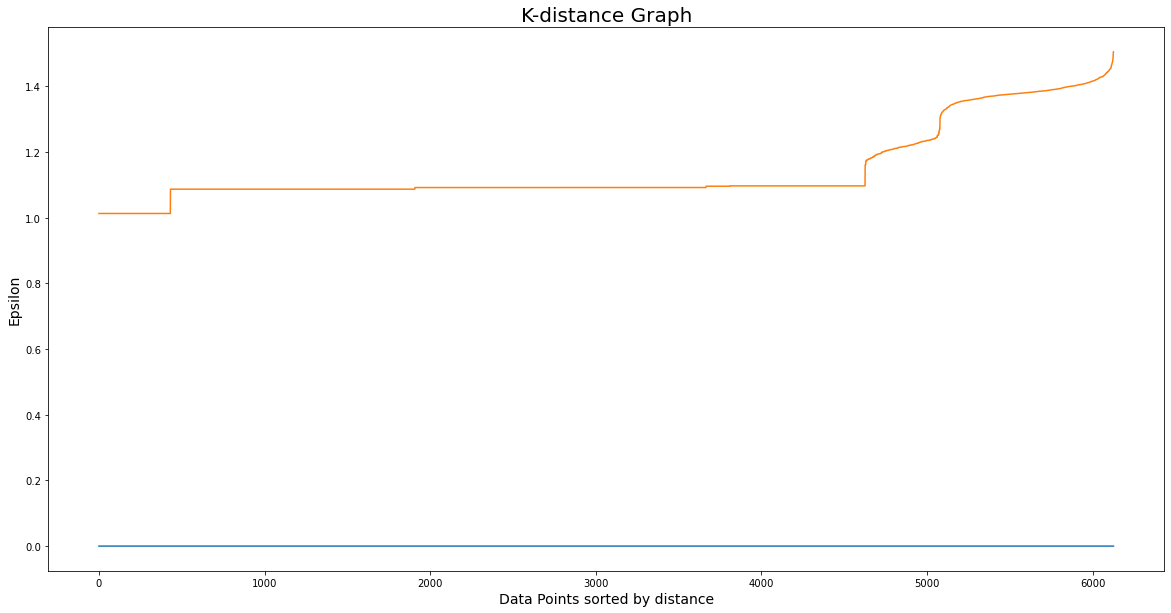

In [202]:
# # Plotting K-distance Graph
# distances = np.sort(distances, axis=0)
# # distances = distances[:,1]
# plt.figure(figsize=(20,10))
# plt.plot(distances)
# plt.title('K-distance Graph',fontsize=20)
# plt.xlabel('Data Points sorted by distance',fontsize=14)
# plt.ylabel('Epsilon',fontsize=14)
# plt.show()